<a href="https://colab.research.google.com/github/Mansisarda1999/Amazon-Apperal-Content-Based-Recommendation/blob/main/Content_Based_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Amazon Apparel Recommendations </h1>



In [ ]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')


## Exploratory Data Analysis


In [ ]:
print ('Number of data points : ', data.shape[0],'Number of features:', data.shape[1])

Number of data points :  183138 Number of features: 19


In [ ]:
data.columns # prints column-names or feature-names.

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

Of these 19 features, we will be using only 6 features.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [ ]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [ ]:
data.head() # prints the top rows in the table.

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


####  Basic stats for the feature: product_type_name

In [ ]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,


count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [ ]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [ ]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

####  Basic stats for the feature: brand

In [ ]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [ ]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [ ]:
print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [ ]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [ ]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [ ]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [ ]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this workshop 
# as they are short and informative.


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [ ]:
##Removing the rows where price is null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [ ]:
## Removing the rows where color is null
data =data.loc[~data['color'].isnull()]

In [ ]:
print('Number of data points after removing duplicates: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16042


In [ ]:
data.to_pickle('16k_apperal_data')
# Storing these products in a pickle file
# candidates who wants to download these files instead 
# of 180K they can download and use them from the Google Drive folder.

# 6. Text pre-processing

In [ ]:
data = pd.read_pickle('16k_apperal_data')
## the stopwords library is downloaded using
# python -m nltk.downloader stopwords command in the anaconda prompt

In [ ]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'hers', 'her', 'were', 'didn', 'some', 'll', 'their', 'herself', 'above', 'my', 'don', 'hadn', 'are', 'up', 'at', 'hasn', 'is', 'it', 'a', "wouldn't", 'further', 'those', 'did', 'by', "couldn't", 'more', "mightn't", 'yourselves', "hasn't", 'him', 'do', 'most', "needn't", "haven't", 'under', "you'll", 'this', 'o', "you'd", 'wasn', 'for', 'haven', 'all', 'them', 'into', 'which', "it's", 'y', 'from', 't', "didn't", 'myself', 'to', 'now', 'but', 'needn', 'm', 'here', "that'll", 'again', "won't", 'after', 's', 'yourself', 'theirs', 'doesn', 'because', 'having', 'in', 'there', 'of', 'itself', 'was', 'she', 'ours', 'i', "you've", 'be', 'if', 'below', "mustn't", 'whom', 'mustn', 'until', 'through', 'each', 'being', 'wouldn', 'he', 'during', 'once', 'down', 'so', 'ma', 'they', 'had', 'any', 'himself', 'our', 'when', 'aren', 'that', 'can', 'nor', 'who', "you're", 'out', 'as', 'before', 'few', 'does', 'the', 'doing', 'yours', 'where', 'have', 'has', 'not', 'just', "should've"

In [ ]:
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

In [ ]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [ ]:
data.to_pickle('16k_apperal_data_preprocessed')

## Text based product similarity

In [ ]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [ ]:
#Display an image
def display_img(url,ax,fig):
    try:
        # we get the url of the apparel and download it
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # we will display it in notebook 
        plt.imshow(img)
    except:
        pass
    #plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
#{this:2,and:0}
    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
            

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Bag of Words (BoW) on product titles.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus
# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

(16042, 12609)

In [ ]:
title_vectorizer.get_feature_names()[1260:12608]

['alpaca',
 'alpacablend',
 'alpha',
 'alphabotanical',
 'alpine',
 'alpinestars',
 'already',
 'alta',
 'alternative',
 'alto',
 'alumni',
 'alunageorge',
 'alvarez',
 'always',
 'alyssa',
 'alyx',
 'amanda',
 'amande',
 'amarillo',
 'amason',
 'amatm',
 'amatmwomens',
 'amazing',
 'amber',
 'ambiance',
 'ambom',
 'ambre',
 'ame',
 'amelia',
 'amendment',
 'america',
 'american',
 'americana',
 'americaninfluence',
 'americas',
 'americawomens',
 'amethyst',
 'ameza',
 'amiracle',
 'amity',
 'amni',
 'amoin',
 'among',
 'amore',
 'amour',
 'amparo',
 'amritsar',
 'amsoil',
 'amstt',
 'amuse',
 'ana',
 'anabel',
 'anaheim',
 'anal',
 'analinne',
 'anarkali',
 'anboo',
 'ancho',
 'anchor',
 'anchorprint',
 'anchors',
 'ancient',
 'and1',
 'andrea',
 'andree',
 'andrew',
 'andy',
 'anemone',
 'anermy',
 'aneu',
 'angashion',
 'angel',
 'angela',
 'angeles',
 'angelic',
 'angelique',
 'angels',
 'angelsleeve',
 'anges',
 'angie',
 'angle',
 'angled',
 'anglehem',
 'angles',
 'angry',
 'an

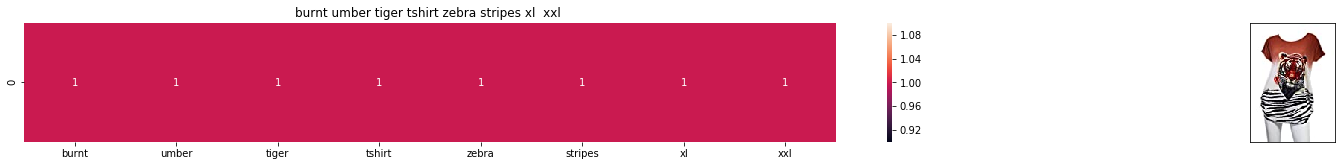

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


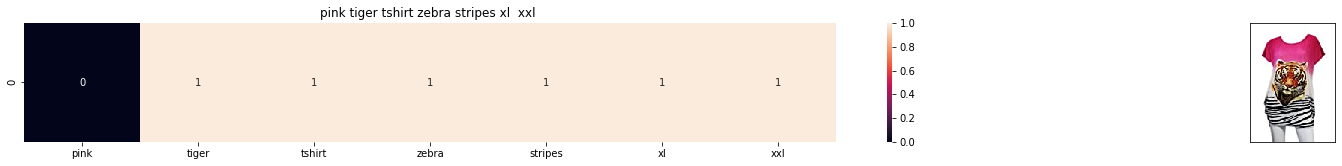

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


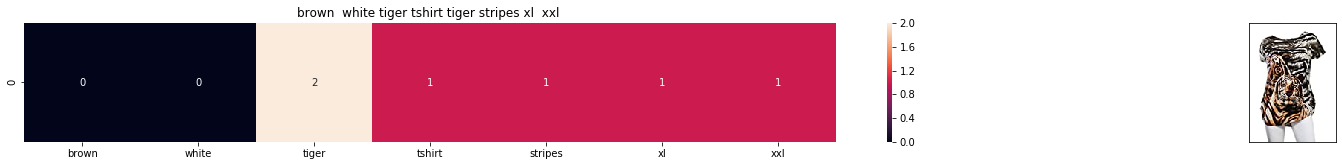

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


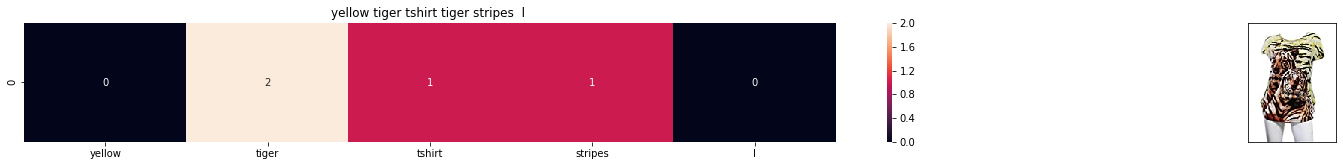

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


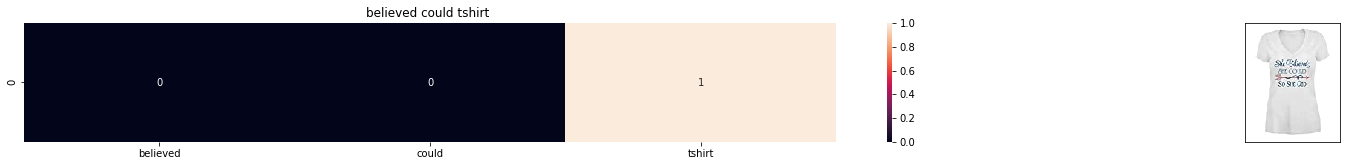

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


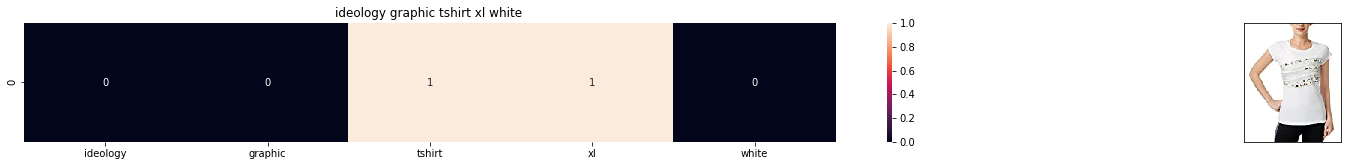

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


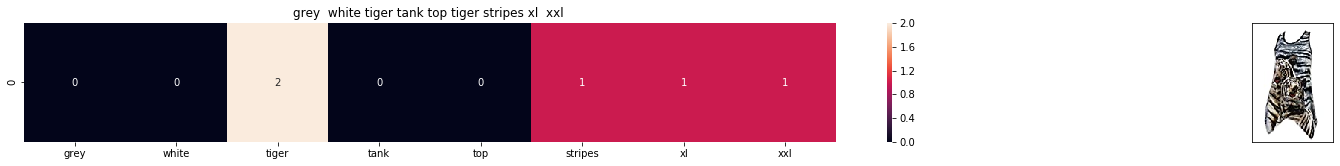

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


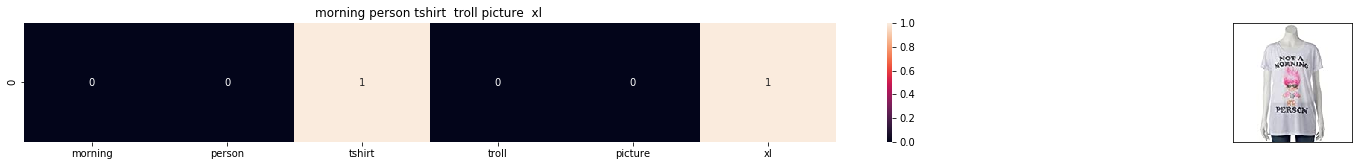

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


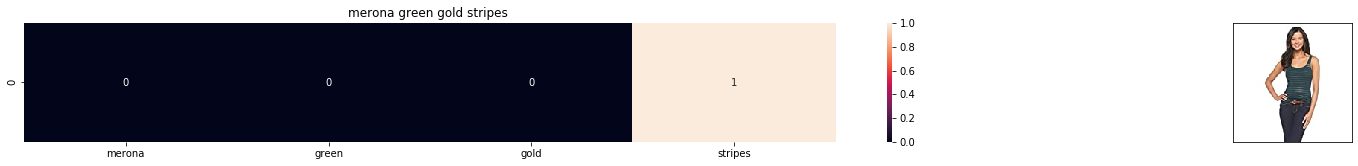

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


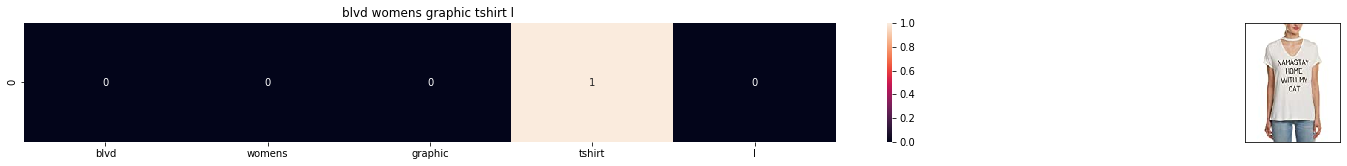

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


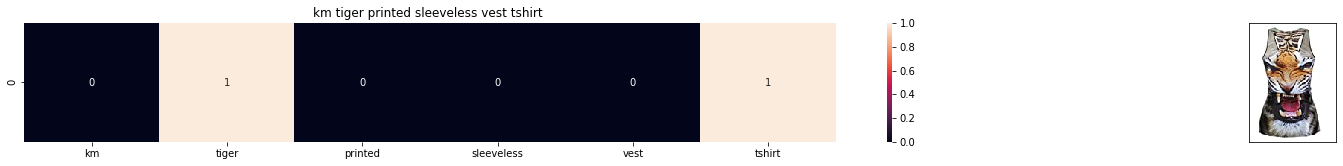

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 3.1622776601683795


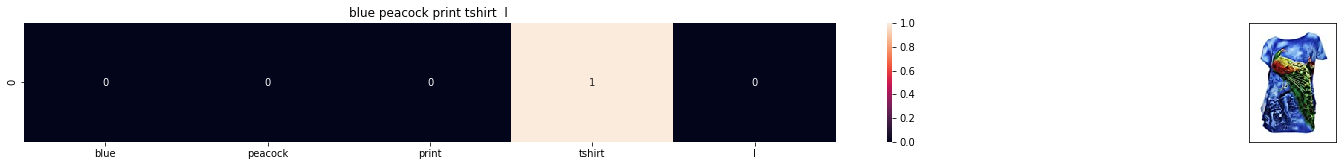

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 3.1622776601683795


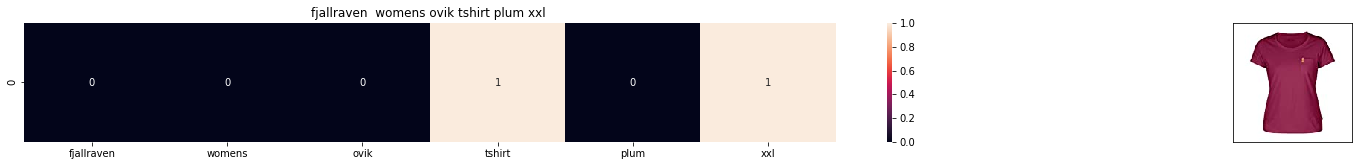

ASIN : B06XC3CZF6
Brand: Fjallraven
Title: fjallraven  womens ovik tshirt plum xxl 
Euclidean similarity with the query image : 3.1622776601683795


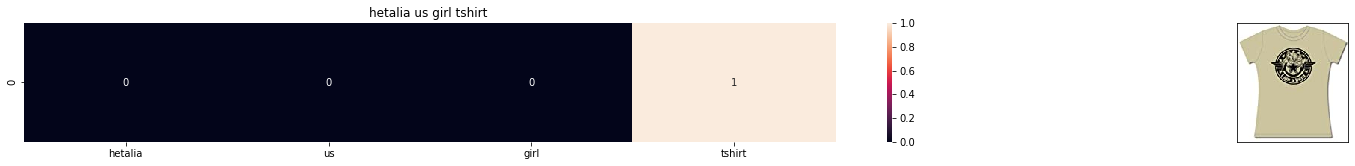

ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 3.1622776601683795


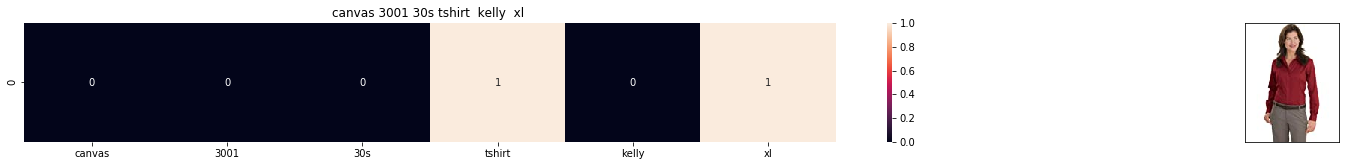

ASIN : B0088PN0LA
Brand: Red House
Title: canvas 3001 30s tshirt  kelly  xl 
Euclidean similarity with the query image : 3.1622776601683795


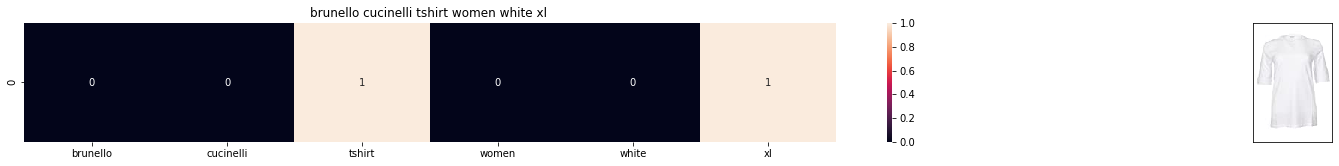

ASIN : B06X99V6WC
Brand: Brunello Cucinelli
Title: brunello cucinelli tshirt women white xl 
Euclidean similarity with the query image : 3.1622776601683795


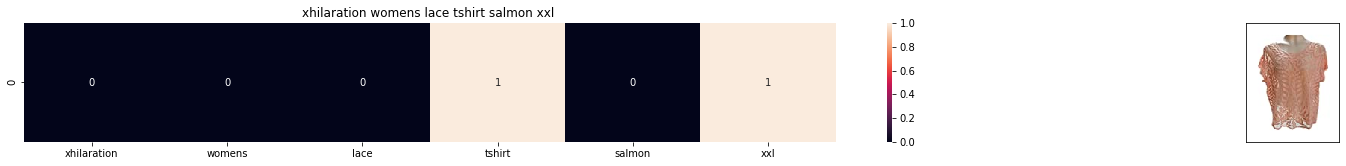

ASIN : B06Y1JPW1Q
Brand: Xhilaration
Title: xhilaration womens lace tshirt salmon xxl 
Euclidean similarity with the query image : 3.1622776601683795


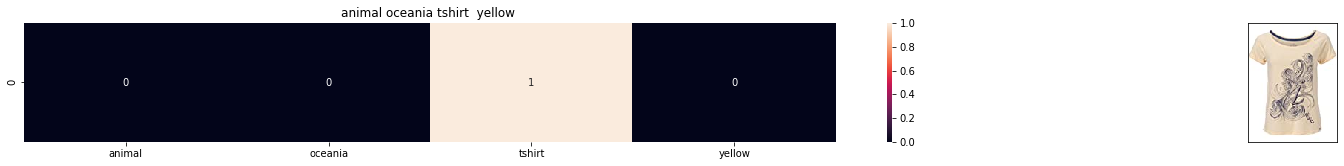

ASIN : B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt  yellow 
Euclidean similarity with the query image : 3.1622776601683795


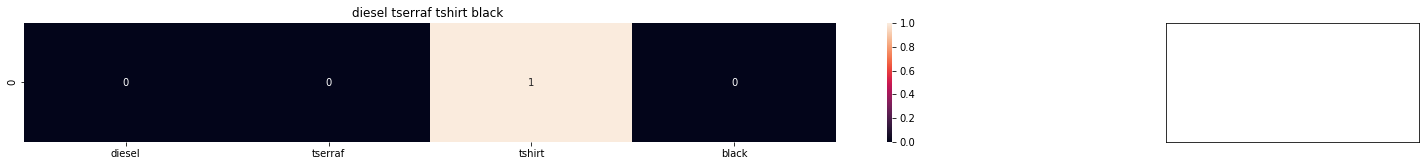

ASIN : B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 3.1622776601683795


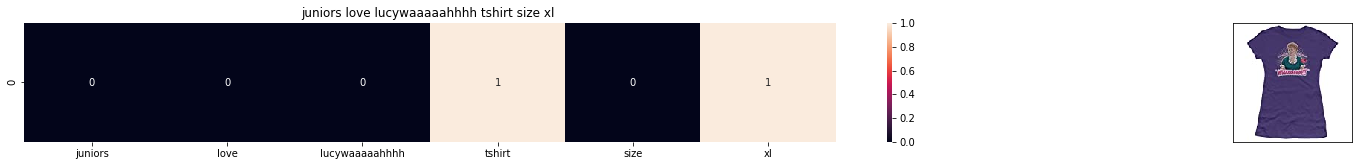

ASIN : B00IAA4JIQ
Brand: I Love Lucy
Title: juniors love lucywaaaaahhhh tshirt size xl 
Euclidean similarity with the query image : 3.1622776601683795


In [ ]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20)
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

## TF-IDF based product similarity

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

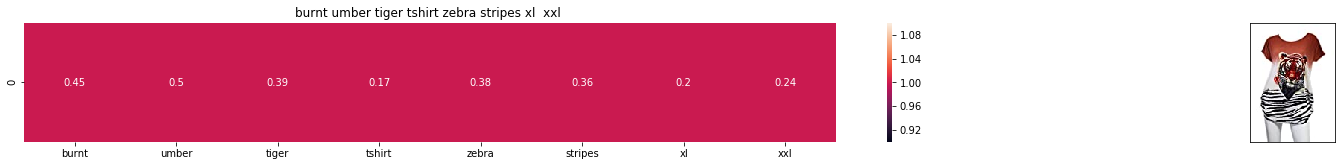

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


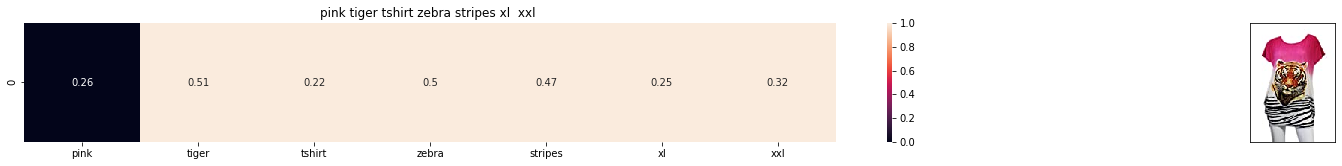

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.7536331912451361


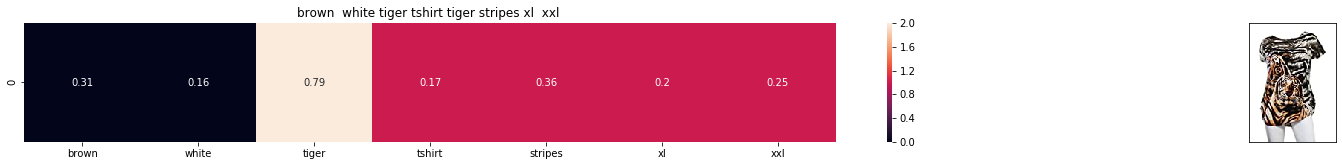

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.9357643943769645


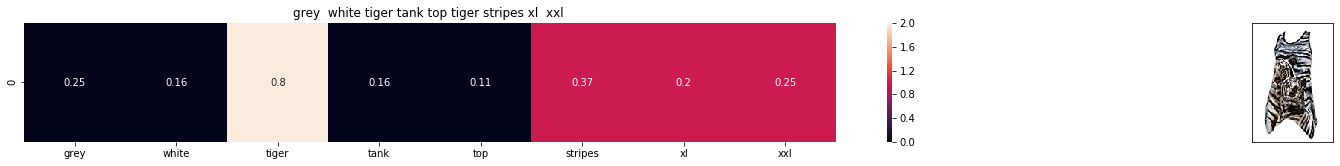

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.9586153524200749


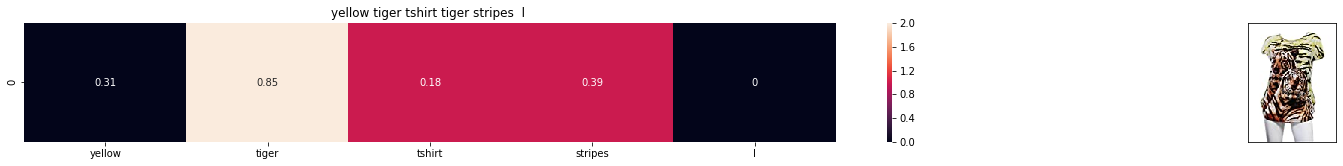

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.000074961446881


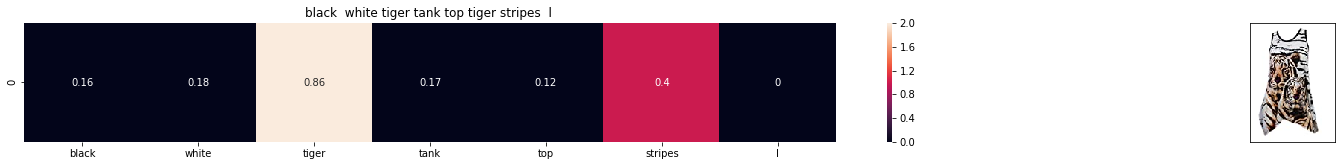

ASIN : B00JXQAO94
BRAND : Si Row
Eucliden distance from the given image : 1.023215552457452


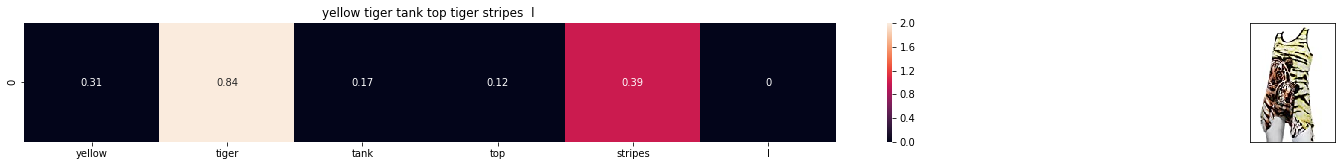

ASIN : B00JXQAUWA
BRAND : Si Row
Eucliden distance from the given image : 1.031991846303421


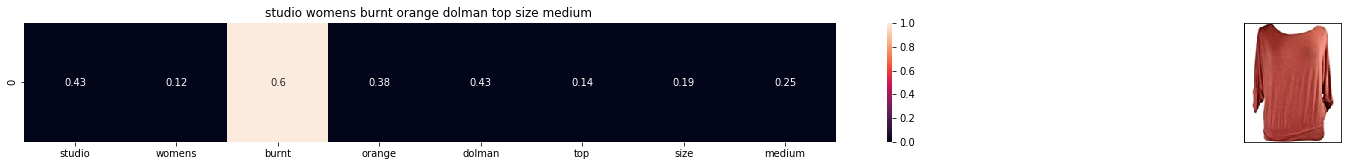

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.2106843670424716


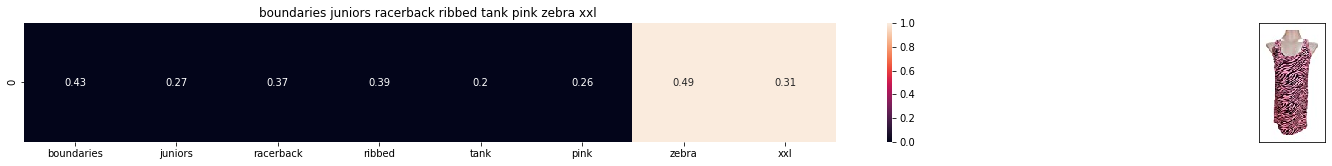

ASIN : B06Y2GTYPM
BRAND : No Boundaries
Eucliden distance from the given image : 1.212168381072083


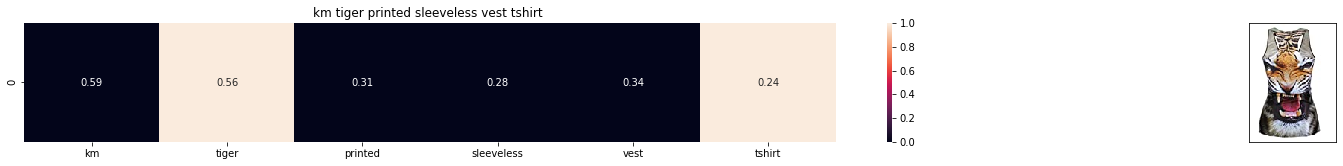

ASIN : B012VQLT6Y
BRAND : KM T-shirt
Eucliden distance from the given image : 1.219790640280982


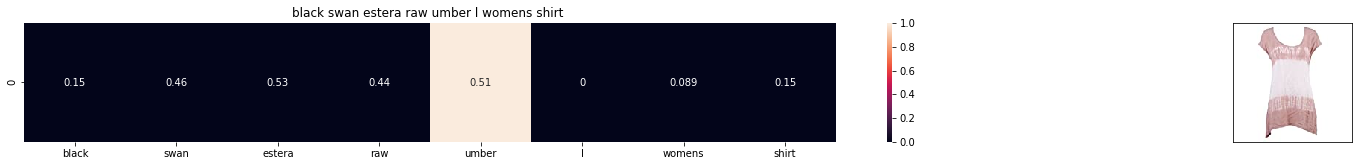

ASIN : B06Y1VN8WQ
BRAND : Black Swan
Eucliden distance from the given image : 1.2206849659998316


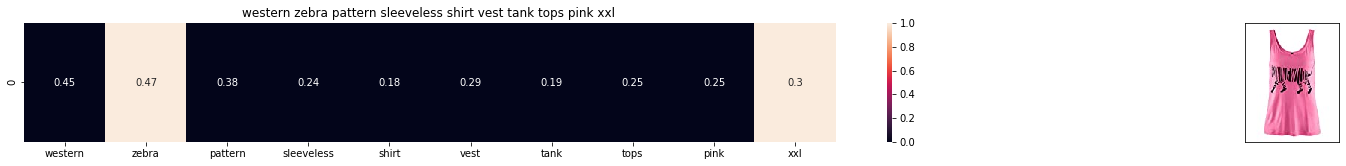

ASIN : B00Z6HEXWI
BRAND : Black Temptation
Eucliden distance from the given image : 1.221281392120943


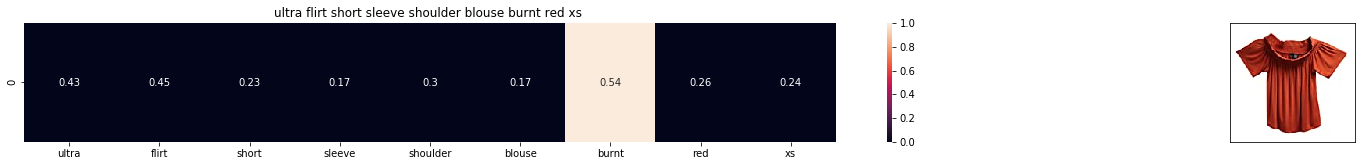

ASIN : B074TR12BH
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.2313364094597743


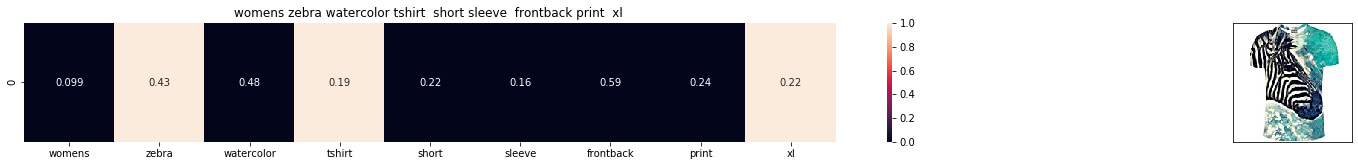

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
Eucliden distance from the given image : 1.2318451972624518


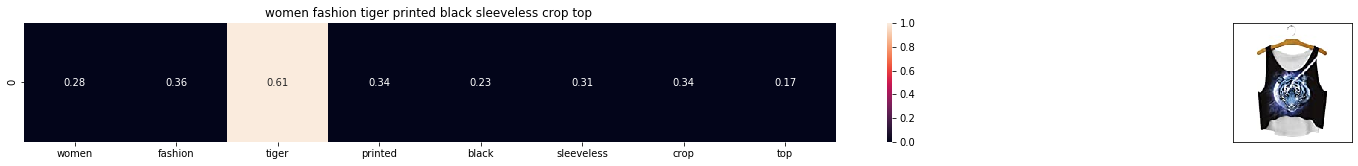

ASIN : B074T8ZYGX
BRAND : MKP Crop Top
Eucliden distance from the given image : 1.2340607457359425


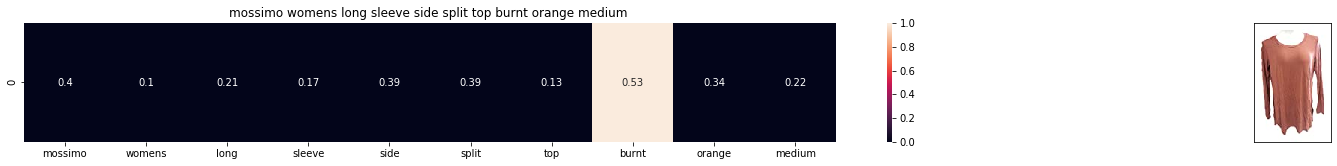

ASIN : B071ZDF6T2
BRAND : Mossimo
Eucliden distance from the given image : 1.2352785577664824


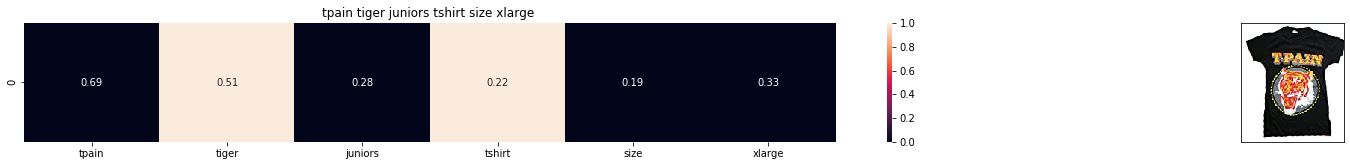

ASIN : B01K0H02OG
BRAND : Tultex
Eucliden distance from the given image : 1.236457298812782


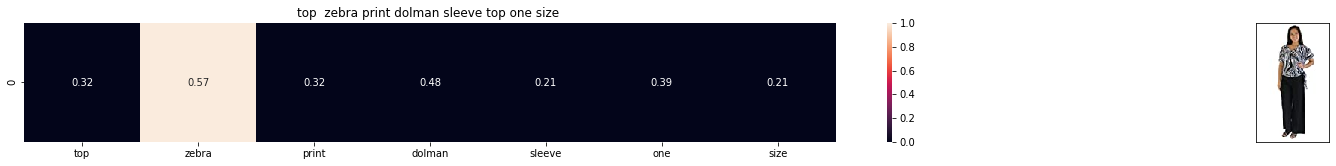

ASIN : B00H8A6ZLI
BRAND : Vivian's Fashions
Eucliden distance from the given image : 1.24996155052848


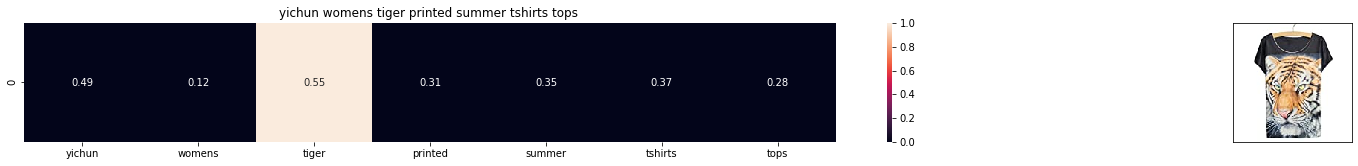

ASIN : B010NN9RXO
BRAND : YICHUN
Eucliden distance from the given image : 1.25354614208561


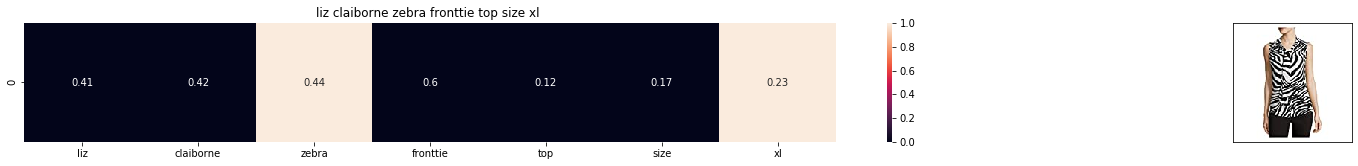

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.2538832938357722


In [ ]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

# W2V model

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [ ]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  tfidf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, tfidf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords) # for each word i summation((tfidf*w2v vector)wi) / total words
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

### Average Word2Vec product similarity.

In [ ]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


In [ ]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

### One hot encoded brand and color features

In [ ]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

## Keras and Tensorflow to extract features

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [ ]:
# https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
# Code reference: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# each image is converted into 25088 length dense-vector

#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

## Visual features based product similarity.

In [ ]:
#w2v_title_weight,brand_features,color_features,bottleneck_features_train

In [ ]:
title_feat = np.dot(w2v_title_weight,0.3)

In [ ]:
brand_feat = np.dot(brand_features,0.2)

In [ ]:
color_feat = np.dot(color_features,0.2)

In [ ]:
image_feat = np.dot(bottleneck_features_train,0.3)

In [ ]:
from scipy.sparse import hstack
data_final = hstack((title_feat,brand_feat, color_feat,image_feat)).tocsr()

In [ ]:
data_final.shape

(16042, 31068)

In [ ]:
import scipy.sparse
scipy.sparse.save_npz('data_final.npz', data_final)

In [ ]:
from sklearn.metrics.pairwise import  euclidean_distances 

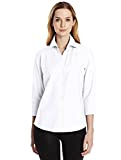

Product Title:  foxcroft nyc womens pinpoint oxford shirt noniron stretch poplin blouse xlarge white 
Euclidean Distance from input image: 0.0
Amazon Url: www.amzon.com/dp/B072277HVB


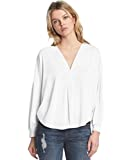

Product Title:  kiind longsleeve swing top white 
Euclidean Distance from input image: 11.417773906587643
Amazon Url: www.amzon.com/dp/B0142Q3C6G


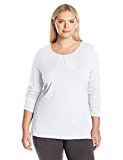

Product Title:  size comfortblend shirred crewneck longsleeve tshirt white 2x 
Euclidean Distance from input image: 12.068139636976188
Amazon Url: www.amzon.com/dp/B01N5YHV9R


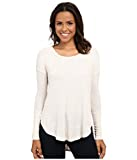

Product Title:  free people scoopneck highlow thermal tunic oatmeal heather 
Euclidean Distance from input image: 12.08556655048217
Amazon Url: www.amzon.com/dp/B00ZH2X45E


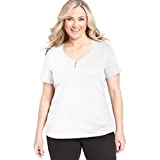

Product Title:  karen scott wmen short sleeve henley top plus size 0x bright white 
Euclidean Distance from input image: 12.088642435849682
Amazon Url: www.amzon.com/dp/B0196H7P5A


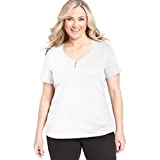

Product Title:  karen scott womens plus short sleeve solid henley top white 1x 
Euclidean Distance from input image: 12.102769906099283
Amazon Url: www.amzon.com/dp/B0196H3Z2W


In [ ]:
def weighted_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = euclidean_distances(data_final,data_final[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    for i in range(len(indices)):
        try:
            rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
            for indx, row in rows.iterrows():
                try:
                    display(Image(url=row['medium_image_url'], embed=True))
                except:
                    pass
                print('Product Title: ', row['title'])
                print('Euclidean Distance from input image:', pdists[i])
                print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])
        except:
            pass
    return indices;
#call the bag-of-words model for a product to get similar products.
indices=weighted_model(12566, 6)
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

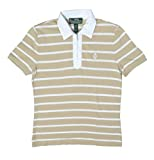

Product Title:  lauren active ralph lauren striped polo shirt khakiwhite xs 
Euclidean Distance from input image: 0.0
Amazon Url: www.amzon.com/dp/B00ILGK6H2


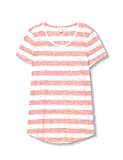

Product Title:  esprit womens womens pink striped tshirt size pink 
Euclidean Distance from input image: 11.820057060018204
Amazon Url: www.amzon.com/dp/B072P2YP84


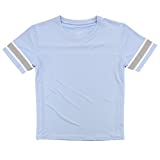

Product Title:  bundle lightweight dri fit sporty top  htc garment guide carolina bluexl 
Euclidean Distance from input image: 11.988234387893238
Amazon Url: www.amzon.com/dp/B073Z1PK7H


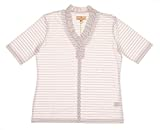

Product Title:  new womens sport haley ruffle stripe short sleeve polo medium white wb111113 
Euclidean Distance from input image: 12.05632876812893
Amazon Url: www.amzon.com/dp/B00V0YMZLC


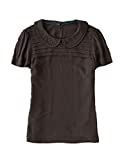

Product Title:  boden taupe peter pan collar top shirt size us 2 
Euclidean Distance from input image: 12.13109171147205
Amazon Url: www.amzon.com/dp/B071YRXR19


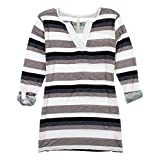

Product Title:  leo  nicole womens 34 sleeve roll tab vneck shirt xs black 
Euclidean Distance from input image: 12.398871340709663
Amazon Url: www.amzon.com/dp/B00U83NJ0W


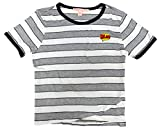

Product Title:  rebellious one juniors blah patch graphic tshirt ivoryhgrey large 
Euclidean Distance from input image: 12.422030246751282
Amazon Url: www.amzon.com/dp/B073RQPTRV


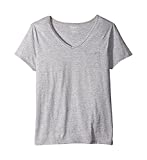

Product Title:  hanes womens short sleeve vneck fusionsoft pocket tee light grey l 
Euclidean Distance from input image: 12.42845774145532
Amazon Url: www.amzon.com/dp/B01DQ74PGS


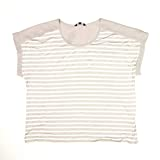

Product Title:  christian siriano womens runway style chiffon sleeve blouse xxlarge grey stripe 
Euclidean Distance from input image: 12.494092478493279
Amazon Url: www.amzon.com/dp/B00L4KJY5M


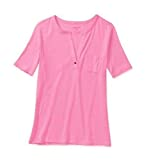

Product Title:  womens short sleeve henley teesmall 46 pink glow 
Euclidean Distance from input image: 12.582468898716042
Amazon Url: www.amzon.com/dp/B01MTV5CN5


In [ ]:
#call the bag-of-words model for a product to get similar products.
indices=weighted_model(1256, 10)
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

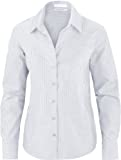

Product Title:  north end ladies cotton striped dress shirt 78674  xxlarge  white  carbon 
Euclidean Distance from input image: 0.0
Amazon Url: www.amzon.com/dp/B00IKF67ZO


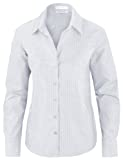

Product Title:  boardwalk ladies wrinkle free 2ply 80s cotton striped taped shirt l white w  carbon 
Euclidean Distance from input image: 3.864866822725363
Amazon Url: www.amzon.com/dp/B00HS5HO1I


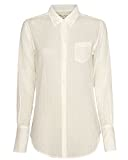

Product Title:  nili lotan womens white striped sheer shirt l 
Euclidean Distance from input image: 9.259835901925397
Amazon Url: www.amzon.com/dp/B06XMYJFWB


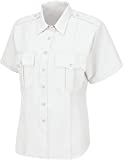

Product Title:  horace small sentry plus shirt white ssxxl 
Euclidean Distance from input image: 9.527530886615528
Amazon Url: www.amzon.com/dp/B00CJVOY5A


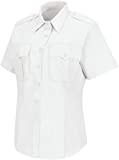

Product Title:  horace small new dimension stretch poplin shirt  white ssxxl 
Euclidean Distance from input image: 9.717491002541978
Amazon Url: www.amzon.com/dp/B00CJVOYKA


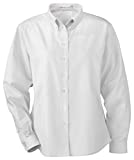

Product Title:  il migliore 77004 ladies wrinkle resistant long sleeve buttondown oxford shirt  white 701  
Euclidean Distance from input image: 9.727847724474543
Amazon Url: www.amzon.com/dp/B00RIB1RF6


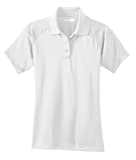

Product Title:  cornerstone red kap  ladies select snagproof tactical poloxxl white cs411 
Euclidean Distance from input image: 9.748639588354932
Amazon Url: www.amzon.com/dp/B00CIZFWLC


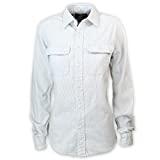

Product Title:  ralph lauren rrl double rl womens long sleeve striped work shirt blue  white size 1 small 
Euclidean Distance from input image: 9.754188944893547
Amazon Url: www.amzon.com/dp/B01K5BRKGK


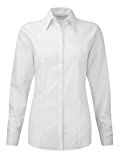

Product Title:  russell collection womens long sleeve herringbon  white  uk 18  us 14  eu 46 
Euclidean Distance from input image: 9.769769945313836
Amazon Url: www.amzon.com/dp/B00K77AN5S


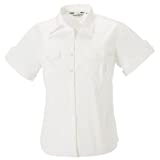

Product Title:  russell collection womensladies short  rollsleeve work shirt 14 us white 
Euclidean Distance from input image: 9.775685557012666
Amazon Url: www.amzon.com/dp/B00K3DX6HS


In [ ]:
indices=weighted_model(1250, 10)